In [1]:
import sys
print(sys.version)

3.9.18 (main, Feb  3 2024, 15:04:55) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]


In [2]:
import numpy as np

# Load the paired dataset from the .npy file
paired_dataset = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/train_input.npy')

# Separate CT and MRI images
num_images = paired_dataset.shape[0]
num_ct_images = num_images // 2

ct_images = paired_dataset[:num_ct_images]
mri_images = paired_dataset[num_ct_images:]

# Check the shapes of the loaded data
print("CT images shape:", ct_images.shape)
print("MRI images shape:", mri_images.shape)


CT images shape: (285, 256, 256)
MRI images shape: (285, 256, 256)


In [3]:
test_data = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/test_input.npy')
val_data = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/val_input.npy')

# Separate CT and MRI images from test dataset
half_length_test = test_data.shape[0] // 2
test_ct_images = test_data[:half_length_test]
test_mri_images = test_data[half_length_test:]

# Separate CT and MRI images from validation dataset
half_length_val = val_data.shape[0] // 2
val_ct_images = val_data[:half_length_val]
val_mri_images = val_data[half_length_val:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate
from tensorflow.keras.optimizers import Adam as AdamLegacy
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

# Assuming ct_images and mri_images are your training data
# Assuming test_ct_images, test_mri_images are your test data
# Assuming val_ct_images, val_mri_images are your validation data

# 1. Preprocess the data
ct_images = ct_images / 255.0
mri_images = mri_images / 255.0
test_ct_images = test_ct_images / 255.0
test_mri_images = test_mri_images / 255.0
val_ct_images = val_ct_images / 255.0
val_mri_images = val_mri_images / 255.0

# 2. Design the model architecture
def fusion_model():
    inputs_ct = Input(shape=(256, 256, 1))
    inputs_mri = Input(shape=(256, 256, 1))
    
    # Convolutional layers for CT image
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_ct)
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_ct)
    
    # Convolutional layers for MRI image
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_mri)
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_mri)
    
    # Concatenate features
    concat = Concatenate()([conv_ct, conv_mri])
    
    # Fusion layer
    fusion = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat)
    
    model = Model(inputs=[inputs_ct, inputs_mri], outputs=fusion)
    return model

# Define VGG19 model outside of tf.function
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False
model_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
model_vgg.trainable = False

@tf.function
def perceptual_loss(y_true, y_pred):
    # Expand dimensions of grayscale images to match VGG input shape
    y_true_rgb = K.repeat_elements(K.expand_dims(y_true, axis=-1), 3, axis=-1)
    y_pred_rgb = K.repeat_elements(K.expand_dims(y_pred, axis=-1), 3, axis=-1)
    
    true_features = model_vgg(y_true_rgb)
    pred_features = model_vgg(y_pred_rgb)
    
    return K.mean(K.square(true_features - pred_features))

model = fusion_model()
optimizer = AdamLegacy()  # Using the legacy Keras optimizer
model.compile(optimizer=optimizer, loss=perceptual_loss)

# 3. Train the model
model.fit([ct_images, mri_images], np.zeros_like(ct_images), epochs=10, batch_size=16, validation_data=([val_ct_images, val_mri_images], np.zeros_like(val_ct_images)))

# 4. Evaluate the model
test_loss = model.evaluate([test_ct_images, test_mri_images], np.zeros_like(test_ct_images))

print("Test Loss:", test_loss)


Epoch 1/10
18/18 [==============================] - 122s 7s/step - loss: 0.0010 - val_loss: 9.4507e-04
Epoch 2/10
12/18 [===================>..........] - ETA: 38s - loss: 8.8351e-04

In [6]:
# After training the model
model.save("fusion_model.h5")


/Users/chintubharath/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Save the trained model in the native Keras format
model.save("fusion_model.h5")

/Users/chintubharath/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 5ms/step


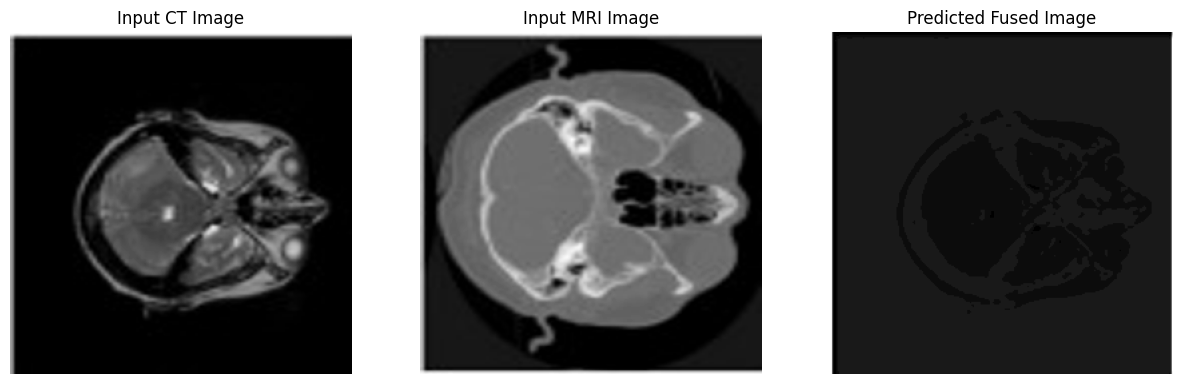

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Define the custom loss function
def perceptual_loss(true, pred):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    loss_model = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    loss_model.trainable = False
    true_features = loss_model(true)
    pred_features = loss_model(pred)
    return tf.reduce_mean(tf.square(true_features - pred_features))

# Load the saved model
model = tf.keras.models.load_model("fusion_model.h5", custom_objects={'perceptual_loss': perceptual_loss})

# Compile the model with custom loss function
model.compile(optimizer='adam', loss=perceptual_loss)

# Load CT and MRI images
ct_image = Image.open('/Volumes/Personal/SDP/ct/WhatsApp Image 2024-02-03 at 17.22.52.jpeg').convert('L')  # Load as grayscale
mri_image = Image.open('/Volumes/Personal/SDP/ct/mri/WhatsApp Image 2024-02-03 at 17.22.52.jpeg').convert('L')  # Load as grayscale

# Resize images to match model input shape
ct_image_resized = ct_image.resize((256, 256))
mri_image_resized = mri_image.resize((256, 256))

# Convert images to numpy arrays
ct_image_np = np.array(ct_image_resized) / 255.0  # Normalize to [0, 1]
mri_image_np = np.array(mri_image_resized) / 255.0  # Normalize to [0, 1]

# Expand dimensions to match model input shape
ct_image_np = np.expand_dims(ct_image_np, axis=-1)
mri_image_np = np.expand_dims(mri_image_np, axis=-1)

# Predict the fused image
fused_image = model.predict([ct_image_np, mri_image_np])

# Convert back to 0-255 range
ct_image_np = (ct_image_np.squeeze() * 255).astype(np.uint8)
mri_image_np = (mri_image_np.squeeze() * 255).astype(np.uint8)
fused_image = (fused_image.squeeze() * 255).astype(np.uint8)

# Save input CT and MRI images
plt.imsave("input_ct_image.jpg", ct_image_np, cmap='gray')
plt.imsave("input_mri_image.jpg", mri_image_np, cmap='gray')

# Save predicted fused image
plt.imsave("predicted_fused_image.jpg", fused_image, cmap='gray')

# Optionally, visualize the input and output images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ct_image_np, cmap='gray')
axes[0].set_title("Input CT Image")
axes[0].axis('off')
axes[1].imshow(mri_image_np, cmap='gray')
axes[1].set_title("Input MRI Image")
axes[1].axis('off')
axes[2].imshow(fused_image, cmap='gray')
axes[2].set_title("Predicted Fused Image")
axes[2].axis('off')
plt.show()


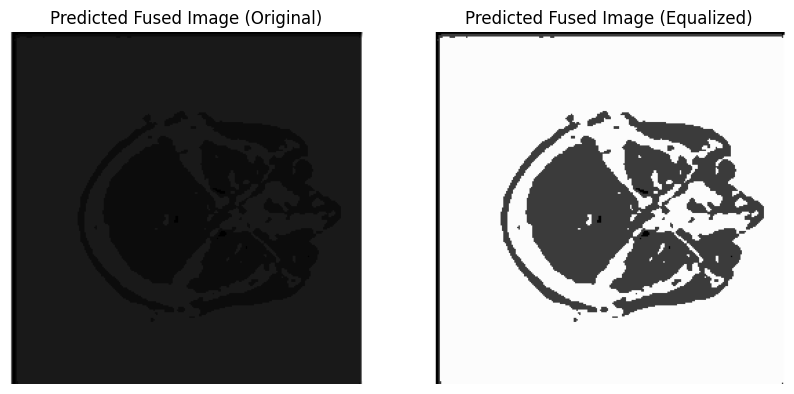

In [21]:
# Apply histogram equalization to enhance visibility
fused_image_equalized = cv2.equalizeHist(fused_image)

# Save predicted fused image after histogram equalization
plt.imsave("predicted_fused_image_equalized.jpg", fused_image_equalized, cmap='gray')

# Optionally, visualize the input and output images with histogram equalization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(fused_image, cmap='gray')
axes[0].set_title("Predicted Fused Image (Original)")
axes[0].axis('off')
axes[1].imshow(fused_image_equalized, cmap='gray')
axes[1].set_title("Predicted Fused Image (Equalized)")
axes[1].axis('off')
plt.show()
